<a href="https://colab.research.google.com/github/RoozbehSanaei/deep-learning-notebooks/blob/master/adversarial_autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Advesarial autoencoders** make use of discriminators to explicitly force encoders to generate latents from a particular distribution, by feeding discriminator with samples of that distribution. So disrimination is performed on latent space rather than image space.

![alt text](https://qph.fs.quoracdn.net/main-qimg-9905a66bb87920a1b84eef07d0fcc40e)

In [1]:
 from __future__ import print_function, division

import keras
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers import MaxPooling2D, merge
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras import losses
from keras.utils import to_categorical
import keras.backend as K

import matplotlib.pyplot as plt

import numpy as np

!mkdir images
!mkdir saved_model

Using TensorFlow backend.


In [0]:
class AdversarialAutoencoder():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 10

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the encoder / decoder
        self.encoder = self.build_encoder()
        self.decoder = self.build_decoder()

        img = Input(shape=self.img_shape)
        # The generator takes the image, encodes it and reconstructs it
        # from the encoding
        encoded_repr = self.encoder(img)
        reconstructed_img = self.decoder(encoded_repr)

        # For the adversarial_autoencoder model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator determines validity of the encoding
        validity = self.discriminator(encoded_repr)

        # The adversarial_autoencoder model  (stacked generator and discriminator)
        self.adversarial_autoencoder = Model(img, [reconstructed_img, validity])
        self.adversarial_autoencoder.compile(loss=['mse', 'binary_crossentropy'],
            loss_weights=[0.999, 0.001],
            optimizer=optimizer)

In [0]:
def build_encoder(self):
    # Encoder

    img = Input(shape=self.img_shape)

    h = Flatten()(img)
    h = Dense(512)(h)
    h = LeakyReLU(alpha=0.2)(h)
    h = Dense(512)(h)
    h = LeakyReLU(alpha=0.2)(h)
    mu = Dense(self.latent_dim)(h)
    log_var = Dense(self.latent_dim)(h)
    mode_f = lambda p: p[0] + K.random_normal(K.shape(p[0])) * K.exp(p[1] / 2)
    

    latent_repr = keras.layers.Lambda(mode_f)([mu, log_var])

    return Model(img, latent_repr)

AdversarialAutoencoder.build_encoder = build_encoder
del build_encoder

In [0]:
def build_decoder(self):

    
    model = Sequential()

    model.add(Dense(512, input_dim=self.latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(np.prod(self.img_shape), activation='tanh'))
    model.add(Reshape(self.img_shape))

    model.summary()

    z = Input(shape=(self.latent_dim,))
    img = model(z)

    return Model(z, img)

AdversarialAutoencoder.build_decoder = build_decoder
del build_decoder

In [0]:
def build_discriminator(self):

    model = Sequential()

    model.add(Dense(512, input_dim=self.latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation="sigmoid"))
    model.summary()

    encoded_repr = Input(shape=(self.latent_dim, ))
    validity = model(encoded_repr)

    return Model(encoded_repr, validity)

AdversarialAutoencoder.build_discriminator = build_discriminator
del build_discriminator

In [0]:
def train(self, epochs, batch_size=128, sample_interval=50):

    # Load the dataset
    (X_train, _), (_, _) = mnist.load_data()

    # Rescale -1 to 1
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = np.expand_dims(X_train, axis=3)

    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random batch of images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        latent_fake = self.encoder.predict(imgs)
        latent_real = np.random.normal(size=(batch_size, self.latent_dim))

        # Train the discriminator
        d_loss_real = self.discriminator.train_on_batch(latent_real, valid)
        d_loss_fake = self.discriminator.train_on_batch(latent_fake, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------

        # Train the generator
        g_loss = self.adversarial_autoencoder.train_on_batch(imgs, [imgs, valid])

        # Plot the progress
        print ("%d [D loss: %f, acc: %.2f%%] [G loss: %f, mse: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss[0], g_loss[1]))

        # If at save interval => save generated image samples
        if epoch % sample_interval == 0:
            self.sample_images(epoch)

AdversarialAutoencoder.train = train
del train

In [0]:
def sample_images(self, epoch):
    r, c = 5, 5

    z = np.random.normal(size=(r*c, self.latent_dim))
    gen_imgs = self.decoder.predict(z)

    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("images/mnist_%d.png" % epoch)
    plt.close()

AdversarialAutoencoder.sample_images = sample_images
del sample_images

In [0]:
def save_model(self):

    def save(model, model_name):
        model_path = "saved_model/%s.json" % model_name
        weights_path = "saved_model/%s_weights.hdf5" % model_name
        options = {"file_arch": model_path,
                    "file_weight": weights_path}
        json_string = model.to_json()
        open(options['file_arch'], 'w').write(json_string)
        model.save_weights(options['file_weight'])

    save(self.generator, "aae_generator")
    save(self.discriminator, "aae_discriminator")

AdversarialAutoencoder.save_model = save_model
del save_model

In [18]:
aae = AdversarialAutoencoder()
aae.train(epochs=20000, batch_size=32, sample_interval=200)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 512)               5632      
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 257       
Total params: 137,217
Trainable params: 137,217
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_5"
_________________________________________________________________
Layer (type)              

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'



0 [D loss: 0.736518, acc: 32.81%] [G loss: 0.937385, mse: 0.937624]


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Streaming output truncated to the last 5000 lines.
15001 [D loss: 0.295156, acc: 87.50%] [G loss: 0.051705, mse: 0.049582]
15002 [D loss: 0.414075, acc: 81.25%] [G loss: 0.060360, mse: 0.058719]
15003 [D loss: 0.370284, acc: 81.25%] [G loss: 0.064837, mse: 0.062736]
15004 [D loss: 0.427726, acc: 82.81%] [G loss: 0.057005, mse: 0.055025]
15005 [D loss: 0.597696, acc: 64.06%] [G loss: 0.071454, mse: 0.069782]
15006 [D loss: 0.444000, acc: 75.00%] [G loss: 0.064560, mse: 0.062885]
15007 [D loss: 0.484629, acc: 75.00%] [G loss: 0.068213, mse: 0.066482]
15008 [D loss: 0.421218, acc: 78.12%] [G loss: 0.066134, mse: 0.064345]
15009 [D loss: 0.423802, acc: 79.69%] [G loss: 0.054819, mse: 0.052881]
15010 [D loss: 0.483633, acc: 75.00%] [G loss: 0.056050, mse: 0.054097]
15011 [D loss: 0.603867, acc: 65.62%] [G loss: 0.057724, mse: 0.056494]
15012 [D loss: 0.185535, acc: 96.88%] [G loss: 0.048363, mse: 0.045986]
15013 [D loss: 0.394556, acc: 79.69%] [G loss: 0.052755, mse: 0.050911]
15014 [D loss

images/mnist_0.png	images/mnist_16000.png	images/mnist_400.png
images/mnist_10000.png	images/mnist_1600.png	images/mnist_4200.png
images/mnist_1000.png	images/mnist_16200.png	images/mnist_4400.png
images/mnist_10200.png	images/mnist_16400.png	images/mnist_4600.png
images/mnist_10400.png	images/mnist_16600.png	images/mnist_4800.png
images/mnist_10600.png	images/mnist_16800.png	images/mnist_5000.png
images/mnist_10800.png	images/mnist_17000.png	images/mnist_5200.png
images/mnist_11000.png	images/mnist_17200.png	images/mnist_5400.png
images/mnist_11200.png	images/mnist_17400.png	images/mnist_5600.png
images/mnist_11400.png	images/mnist_17600.png	images/mnist_5800.png
images/mnist_11600.png	images/mnist_17800.png	images/mnist_6000.png
images/mnist_11800.png	images/mnist_18000.png	images/mnist_600.png
images/mnist_12000.png	images/mnist_1800.png	images/mnist_6200.png
images/mnist_1200.png	images/mnist_18200.png	images/mnist_6400.png
images/mnist_12200.png	images/mnist_18400.png	images/mnist

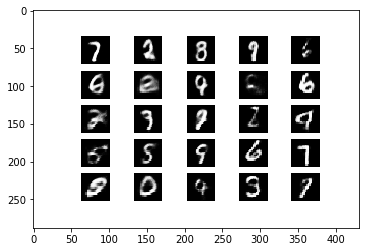

In [20]:
!ls images/*
img = plt.imread("images/mnist_9800.png")
plt.imshow(img)